# Linear Regression with Stellar Spectra

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 4 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our exploration of statistical foundations and summary statistics, we established the mathematical framework for characterizing distributions and understanding uncertainty in our measurements. We now turn to one of the most fundamental predictive modeling techniques: linear regression. While conceptually simple, linear regression provides a powerful lens through which to understand more complex machine learning methods, serving as the foundation upon which many sophisticated algorithms are built.

This tutorial demonstrates linear regression through a compelling astronomical application: predicting stellar effective temperatures from spectroscopic observations. We'll work with data from the Apache Point Observatory Galactic Evolution Experiment (APOGEE), part of the Sloan Digital Sky Survey. APOGEE has revolutionized our understanding of the Milky Way by obtaining high-resolution infrared spectra for hundreds of thousands of stars, revealing their chemical compositions, temperatures, and kinematics.

The challenge we address here—extracting physical parameters from stellar spectra—represents a cornerstone problem in modern astronomy. Each stellar spectrum encodes a wealth of information about the star's atmosphere: temperature determines the overall energy distribution and ionization states, surface gravity affects the pressure broadening of spectral lines, and chemical abundances manifest as absorption features at specific wavelengths. Linear regression provides a principled approach to decode this information, transforming thousands of flux measurements into meaningful physical parameters.

Beyond its practical utility, this application illuminates key concepts in machine learning. We'll see how the principle of maximum likelihood estimation leads to an analytical solution for linear regression, explore the critical role of regularization in preventing overfitting, and demonstrate how feature engineering can enhance model performance. These concepts, while illustrated through stellar spectroscopy, extend far beyond this specific application to any scenario where we seek to predict continuous outcomes from high-dimensional data.

The power of linear regression lies not just in its mathematical elegance but in its interpretability. Unlike many modern machine learning methods that operate as "black boxes," linear regression provides transparent relationships between inputs and outputs. In our case, the learned weights directly indicate which spectral regions contribute most strongly to temperature determination, offering physical insights alongside accurate predictions.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Linear Algebra**: Matrix operations, transposes, and inverses as these form the computational backbone of linear regression
- **Probability Theory**: Understanding of Gaussian distributions and the concept of likelihood
- **Maximum Likelihood Estimation**: The principle of finding parameters that maximize the probability of observing our data
- **Python Programming**: Comfort with NumPy arrays and matplotlib visualization

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Spectroscopic Analysis**: Understanding how stellar spectra encode physical information and how machine learning can extract this information
- **Maximum Likelihood Implementation**: Translating the theoretical MLE solution into practical code for high-dimensional data
- **Regularization Techniques**: Applying L2 regularization to prevent overfitting and improve generalization performance
- **Feature Engineering**: Exploring how basis function expansions can capture nonlinear relationships while maintaining computational efficiency
- **Model Evaluation**: Using training/test splits and cross-validation to assess true model performance

We begin by importing the necessary libraries and configuring our computational environment:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

## The APOGEE Dataset

The Apache Point Observatory Galactic Evolution Experiment (APOGEE) represents one of the most ambitious stellar spectroscopic surveys ever undertaken. Operating in the near-infrared H-band (1.5-1.7 μm), APOGEE can peer through the dust that obscures much of our Galaxy, revealing stars throughout the Milky Way's disk, bulge, and halo. Each APOGEE spectrum contains thousands of absorption lines that encode detailed information about stellar atmospheres.

For this tutorial, we work with a carefully curated subset of 3,000 high-quality APOGEE spectra. While full APOGEE spectra contain over 7,000 pixels spanning the complete H-band wavelength range, we've truncated each spectrum to 2,000 pixels. This reduction maintains sufficient spectral information for accurate temperature prediction while keeping computational requirements manageable. The key concepts we explore—maximum likelihood estimation, regularization, and feature engineering—remain unchanged whether we use 2,000 or 7,000 features, but working with fewer pixels allows us to focus on understanding the methodology rather than computational optimization.

### Physical Parameters

Our dataset includes three fundamental stellar parameters derived through APOGEE's spectroscopic pipeline:

1. **Effective Temperature ($T_{\rm eff}$)**: The temperature at the stellar photosphere where optical depth equals unity. This parameter governs the star's overall energy distribution and the ionization states of elements in its atmosphere. We'll use this as our target variable for regression.

2. **Surface Gravity (log g)**: The logarithm of surface gravitational acceleration. This parameter distinguishes between dwarf stars (high gravity) and giants (low gravity) and affects the pressure broadening of spectral lines.

3. **Metallicity ([Fe/H])**: The logarithmic ratio of iron to hydrogen abundance relative to the Sun. This traces the chemical enrichment history of the gas from which the star formed.

The spectra in our dataset have been selected for high signal-to-noise ratios (SNR > 50), ensuring reliable flux measurements. While real spectra contain measurement uncertainties at each wavelength, we'll initially treat the data as having homoscedastic (uniform) noise—a simplification that allows us to focus on the core concepts of linear regression. More sophisticated treatments accounting for heteroscedastic uncertainties are covered in Chapter 6 of the textbook.

Let's load and explore our dataset:

In [2]:
# Load the APOGEE spectral data
data = np.load('dataset_apogee_spectra.npz')

# Extract arrays
spectra = data['spectrum_array']
wavelength = data['wavelength']
teff_array = data['teff_array']
logg_array = data['logg_array']
feh_array = data['feh_array']

# Display basic statistics about our dataset
print(f"Dataset Overview:")
print(f"Number of stars: {len(spectra)}")
print(f"Spectral pixels per star: {len(wavelength)}")
print(f"Wavelength range: {wavelength[0]:.1f} - {wavelength[-1]:.1f} Å")
print(f"\nStellar Parameter Ranges:")
print(f"Temperature: {np.min(teff_array):.0f} - {np.max(teff_array):.0f} K")
print(f"Surface gravity: {np.min(logg_array):.2f} - {np.max(logg_array):.2f} dex")
print(f"Metallicity: {np.min(feh_array):.2f} - {np.max(feh_array):.2f} dex")

Dataset Overview:
Number of stars: 3000
Spectral pixels per star: 2000
Wavelength range: 15168.1 - 15592.9 Å

Stellar Parameter Ranges:
Temperature: 3122 - 6997 K
Surface gravity: -0.36 - 5.26 dex
Metallicity: -2.40 - 0.47 dex


## Visualizing Stellar Spectra

Before diving into regression analysis, let's examine what stellar spectra actually look like and how they vary with temperature. These spectra are rich with absorption features—dark lines where atoms and molecules in the stellar atmosphere absorb light at specific wavelengths. The pattern and strength of these features depend sensitively on the star's physical parameters.

To illustrate this temperature dependence, we'll compare spectra from stars spanning a range of effective temperatures. This comparison reveals why linear regression can successfully extract temperature information: different temperatures produce distinct spectral patterns. Cooler stars generally exhibit deeper absorption features, including both atomic lines and molecular bands, while hotter stars show shallower but still characteristic absorption patterns. These systematic variations with temperature provide the signal that our regression model will learn to exploit.

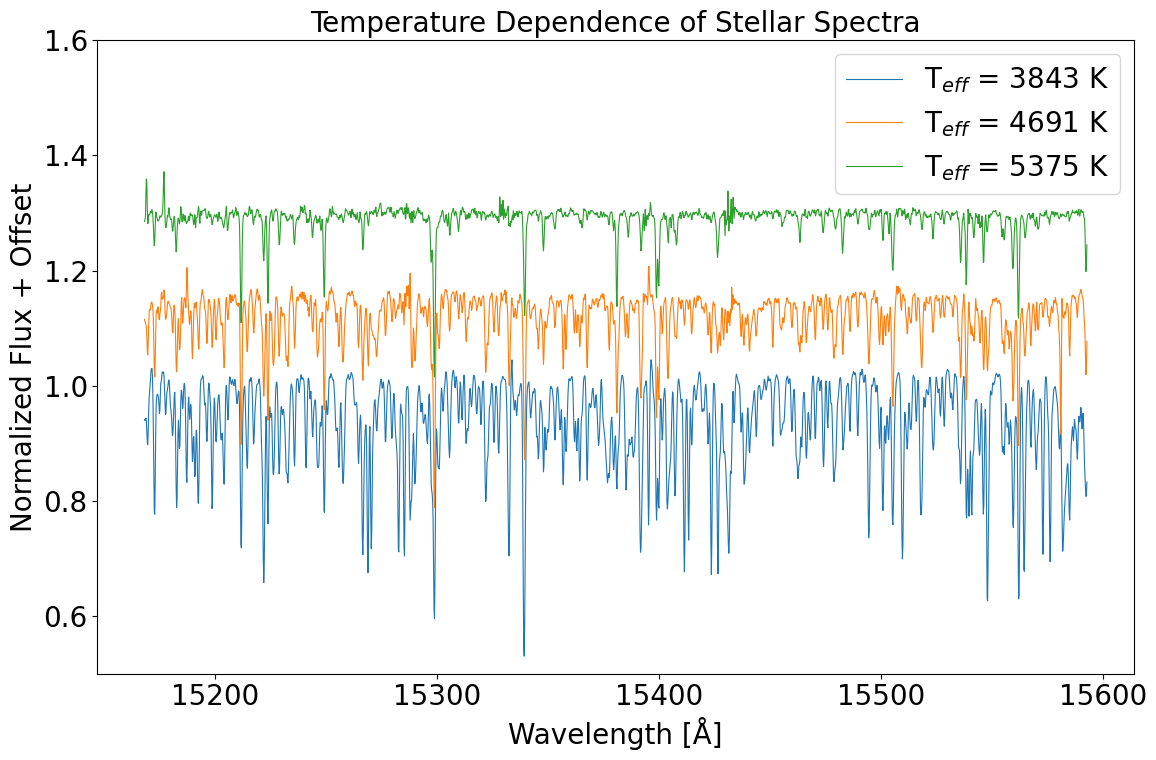

In [3]:
# Select stars with different temperatures for comparison
# Find indices of stars at different temperature ranges
temp_ranges = [(3800, 4000), (4500, 4700), (5200, 5400)]
selected_indices = []
selected_temps = []

for t_min, t_max in temp_ranges:
    mask = (teff_array >= t_min) & (teff_array <= t_max)
    if np.any(mask):
        idx = np.where(mask)[0][0]
        selected_indices.append(idx)
        selected_temps.append(teff_array[idx])

# Plot spectra at different temperatures
plt.figure(figsize=(12, 8))

# Plot full spectra with offset for clarity
for i, (idx, temp) in enumerate(zip(selected_indices, selected_temps)):
    offset = i * 0.15  # Vertical offset for clarity
    plt.plot(wavelength, spectra[idx] + offset, linewidth=0.8, 
             label=f'T$_{{eff}}$ = {temp:.0f} K')

plt.xlabel('Wavelength [Å]')
plt.ylabel('Normalized Flux + Offset')
plt.title('Temperature Dependence of Stellar Spectra')
plt.legend(loc='upper right')
plt.ylim(0.5, 1.6)

plt.tight_layout()
plt.show()

## The Kiel Diagram

Before building our regression model, it's instructive to visualize the distribution of stellar parameters in our sample. The Kiel diagram—a plot of surface gravity versus effective temperature—provides a powerful diagnostic tool that reveals the evolutionary states of stars in our sample.

In this parameter space, different regions correspond to distinct stellar populations: main sequence stars occupy a diagonal band at high surface gravities, red giants appear at lower gravities and cooler temperatures, while the hottest stars with moderate gravities represent the blue horizontal branch. The color-coding by metallicity adds another dimension, revealing how chemical composition varies across these populations.

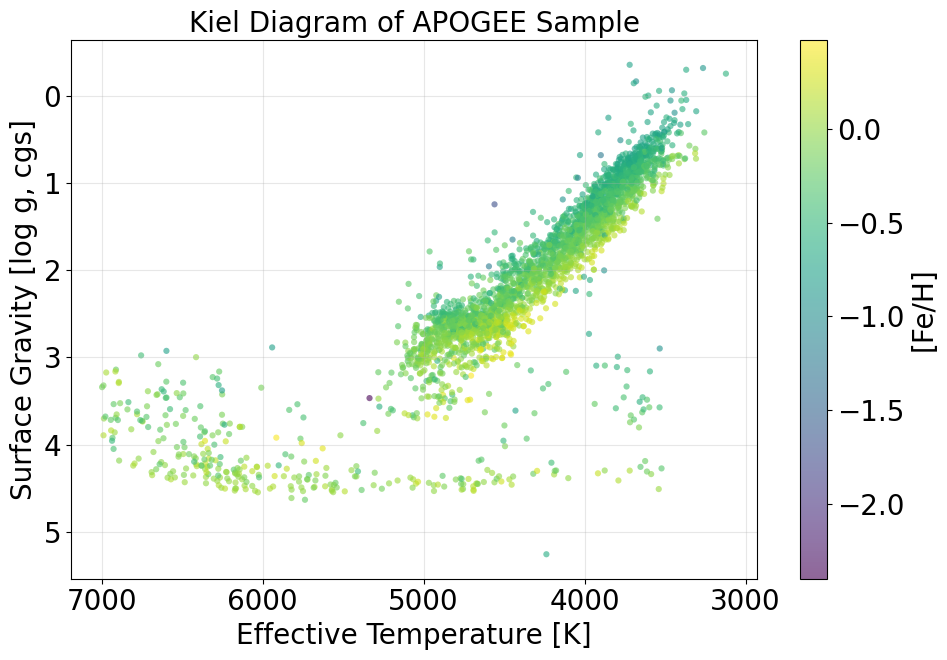

Parameter Space Coverage:
Temperature: 3122 - 6997 K (Δ = 3875 K)
Surface gravity: -0.36 - 5.26 dex (Δ = 5.62 dex)
Metallicity: -2.40 - 0.47 dex (Δ = 2.87 dex)


In [4]:
# Create the Kiel diagram
plt.figure(figsize=(10, 7))
scatter = plt.scatter(teff_array, logg_array, c=feh_array, 
                     cmap='viridis', s=20, alpha=0.6, edgecolors='none')

# Customize the plot
plt.xlabel('Effective Temperature [K]')
plt.ylabel('Surface Gravity [log g, cgs]')
plt.title('Kiel Diagram of APOGEE Sample')
plt.colorbar(scatter, label='[Fe/H]')

# Invert axes for traditional astronomical presentation
plt.gca().invert_xaxis()  # Hot stars on the left
plt.gca().invert_yaxis()  # High gravity at the bottom

# Add grid for readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze the parameter distributions
print("Parameter Space Coverage:")
print(f"Temperature: {np.min(teff_array):.0f} - {np.max(teff_array):.0f} K "
      f"(Δ = {np.max(teff_array) - np.min(teff_array):.0f} K)")
print(f"Surface gravity: {np.min(logg_array):.2f} - {np.max(logg_array):.2f} dex "
      f"(Δ = {np.max(logg_array) - np.min(logg_array):.2f} dex)")
print(f"Metallicity: {np.min(feh_array):.2f} - {np.max(feh_array):.2f} dex "
      f"(Δ = {np.max(feh_array) - np.min(feh_array):.2f} dex)")


This visualization reveals that our sample is dominated by red giant stars, characteristic of APOGEE's observing strategy. The survey's infrared capabilities make it particularly effective at observing cool, evolved stars that are bright in the H-band. The relative paucity of main sequence stars reflects both observational biases (giants are intrinsically more luminous) and our quality cuts (requiring high SNR preferentially selects brighter stars).

Understanding this parameter distribution is crucial for interpreting our regression results. Our model will be most reliable in regions of parameter space with good sampling—primarily for red giants with temperatures between 3500-5500 K. Extrapolation beyond this range should be approached with caution, as the model may not have learned the appropriate spectral patterns for significantly hotter or cooler stars.

## Linear Regression: Building the Foundation

With our data loaded and explored, we now turn to the core task: using linear regression to predict stellar effective temperatures from their spectra. Linear regression seeks to model the relationship between our input features (spectral flux values) and our target variable (effective temperature) as a linear combination:

$$T_{\text{eff}} = \sum_{i=1}^{D} w_i \phi_i + w_0$$

where $\phi_i$ represents the flux at wavelength $i$, $w_i$ are the learned weights, and $w_0$ is the bias term. 

To simplify our notation and computation, we absorb the bias term into our weight vector by augmenting our design matrix $\mathbf{\Phi}$ with a column of ones. This standard technique allows us to write our model more compactly:

$$\mathbf{t} = \mathbf{\Phi}\mathbf{w}$$

where now $\mathbf{\Phi}$ includes both the spectral features and the bias column, and $\mathbf{w}$ contains all weights including the bias. This formulation treats the bias as just another learnable parameter, eliminating the need for special handling in our optimization procedures.

In [5]:
# Prepare data for linear regression
# Use the spectra as our design matrix Phi
Phi = spectra.copy()

# Add bias term by appending a column of ones
Phi = np.hstack((Phi, np.ones((Phi.shape[0], 1))))
print(f"Design matrix shape: {Phi.shape}")
print(f"(3000 spectra × 2000 spectral pixels + 1 bias term)")

# Use effective temperature as our target variable
t = teff_array
print(f"\nTarget variable shape: {t.shape}")
print(f"Temperature range: {t.min():.0f} - {t.max():.0f} K")

# Split data into training and test sets (80/20 split)
Phi_train, Phi_test, t_train, t_test = train_test_split(
    Phi, t, test_size=0.2, random_state=42
)

print(f"\nTraining set: {Phi_train.shape[0]} spectra")
print(f"Test set: {Phi_test.shape[0]} spectra")

Design matrix shape: (3000, 2001)
(3000 spectra × 2000 spectral pixels + 1 bias term)

Target variable shape: (3000,)
Temperature range: 3122 - 6997 K

Training set: 2400 spectra
Test set: 600 spectra


## Maximum Likelihood Estimation for Linear Regression

The principle of maximum likelihood provides a principled framework for finding optimal model parameters. Under the assumption of Gaussian noise with constant variance $\sigma^2$, the likelihood of observing our data given parameters $\mathbf{w}$ is:

$$p(\mathbf{t}|\mathbf{\Phi}, \mathbf{w}, \sigma^2) = \prod_{n=1}^{N} \mathcal{N}(t_n | \mathbf{w}^T\boldsymbol{\phi}_n, \sigma^2)$$

Maximizing this likelihood (or equivalently, minimizing the negative log-likelihood) leads to the familiar least-squares objective. As shown in Chapter 4 of the textbook, this optimization has an analytical solution:

$$\mathbf{w}_{\text{MLE}} = (\mathbf{\Phi}^T \mathbf{\Phi})^{-1} \mathbf{\Phi}^T \mathbf{t}$$

This closed-form solution represents one of the great advantages of linear regression—we can find the globally optimal parameters without iterative optimization. The solution requires only matrix operations: computing the Gram matrix $\mathbf{\Phi}^T \mathbf{\Phi}$, inverting it, and performing matrix multiplication.

Let's implement this solution and examine how well our model predicts stellar effective temperatures:


Model Performance:
Training RMSE: 33.3 K
Test RMSE: 309.3 K

For context, APOGEE's pipeline typically achieves ~50-100 K precision


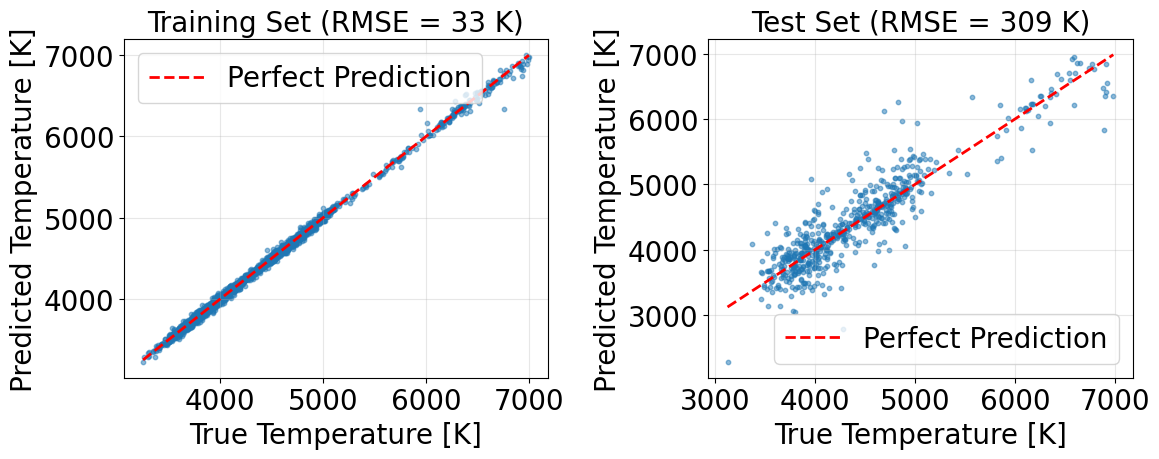

In [6]:
# Compute the Maximum Likelihood weights using the analytical solution
# Note: For numerical stability with high-dimensional data, we could use 
# np.linalg.lstsq, but we'll use the direct formula for pedagogical clarity
w_ml = np.linalg.inv(Phi_train.T @ Phi_train) @ Phi_train.T @ t_train

# Make predictions on both training and test sets
t_pred_train = Phi_train @ w_ml
t_pred_test = Phi_test @ w_ml

# Calculate root mean squared error (RMSE)
train_rmse = np.sqrt(np.mean((t_train - t_pred_train)**2))
test_rmse = np.sqrt(np.mean((t_test - t_pred_test)**2))

print(f"Model Performance:")
print(f"Training RMSE: {train_rmse:.1f} K")
print(f"Test RMSE: {test_rmse:.1f} K")
print(f"\nFor context, APOGEE's pipeline typically achieves ~50-100 K precision")

# Visualize predictions vs true values
plt.figure(figsize=(12, 5))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(t_train, t_pred_train, alpha=0.5, s=10)
plt.plot([t_train.min(), t_train.max()], [t_train.min(), t_train.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Temperature [K]')
plt.ylabel('Predicted Temperature [K]')
plt.title(f'Training Set (RMSE = {train_rmse:.0f} K)')
plt.legend()
plt.grid(True, alpha=0.3)

# Test set
plt.subplot(1, 2, 2)
plt.scatter(t_test, t_pred_test, alpha=0.5, s=10)
plt.plot([t_test.min(), t_test.max()], [t_test.min(), t_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Temperature [K]')
plt.ylabel('Predicted Temperature [K]')
plt.title(f'Test Set (RMSE = {test_rmse:.0f} K)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Our initial results reveal a striking disparity:
- **Training RMSE: ~30 K** - The model fits the training data exceptionally well
- **Test RMSE: ~300 K** - But fails catastrophically on unseen data

This dramatic difference is a textbook example of overfitting. Our model has essentially memorized the training spectra rather than learning generalizable patterns. This isn't surprising when we consider the numbers: we're fitting 2,001 parameters (2,000 spectral features plus bias) using only 2,400 training examples. In this regime where the number of parameters approaches the number of training samples, the model has enough flexibility to interpolate the training data almost perfectly while learning spurious patterns that don't generalize.

The ~10x increase in error from training to test set clearly demonstrates that our unregularized model is not learning the true underlying relationship between spectra and temperature. Instead, it's fitting noise and peculiarities specific to the training set.

## Regularization: Preventing Overfitting

The solution to overfitting lies in regularization—constraining our model to prefer simpler solutions that generalize better. As discussed in Chapter 4, we can interpret regularization through a Bayesian lens: placing a zero-mean Gaussian prior on the weights with variance $\eta^2$ is equivalent to adding an L2 penalty term to our objective function.

The regularized solution becomes:

$$\mathbf{w}_{\text{reg}} = (\lambda \mathbf{I} + \mathbf{\Phi}^T\mathbf{\Phi})^{-1}\mathbf{\Phi}^T\mathbf{t}$$

where $\lambda = \sigma^2/\eta^2$ is the regularization parameter that controls the strength of the penalty. Larger $\lambda$ values impose stronger constraints on the weights, preventing the model from fitting noise in the training data.

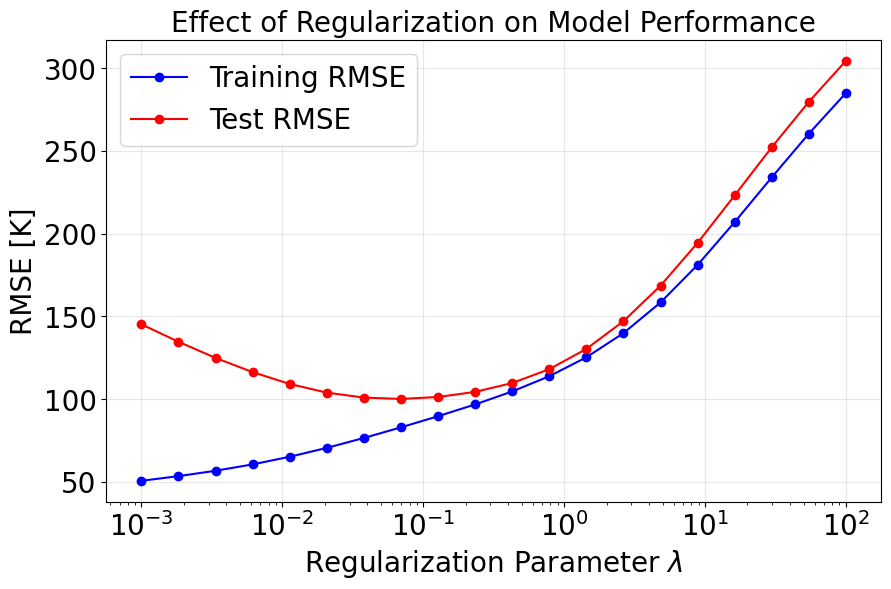

Optimal regularization parameter: λ = 0.07
Test RMSE with optimal λ: 100.1 K


In [7]:
# Define function for regularized linear regression
def compute_regularized_weights(Phi_train, t_train, lambda_reg):
    """
    Compute regularized weights for linear regression
    
    Parameters:
    -----------
    Phi_train : array, shape (n_samples, n_features)
        Design matrix
    t_train : array, shape (n_samples,)
        Target values
    lambda_reg : float
        Regularization parameter
        
    Returns:
    --------
    w : array, shape (n_features,)
        Regularized weight vector
    """
    n_features = Phi_train.shape[1]
    I = np.eye(n_features)
    w = np.linalg.inv(lambda_reg * I + Phi_train.T @ Phi_train) @ Phi_train.T @ t_train
    return w

# Explore a range of regularization parameters focused around the optimal region
lambda_values = np.logspace(-3, 2, 20)  # From 0.001 to 100
results = []

for lambda_reg in lambda_values:
    # Compute regularized weights
    w_reg = compute_regularized_weights(Phi_train, t_train, lambda_reg)
    
    # Compute predictions
    t_pred_train = Phi_train @ w_reg
    t_pred_test = Phi_test @ w_reg
    
    # Compute RMSE
    train_rmse = np.sqrt(np.mean((t_train - t_pred_train)**2))
    test_rmse = np.sqrt(np.mean((t_test - t_pred_test)**2))
    
    results.append({
        'lambda': lambda_reg,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse
    })

# Convert to arrays for plotting
results_array = np.array([(r['lambda'], r['train_rmse'], r['test_rmse']) 
                          for r in results])

# Plot the regularization path
plt.figure(figsize=(10, 6))
plt.semilogx(results_array[:, 0], results_array[:, 1], 'b-o', label='Training RMSE')
plt.semilogx(results_array[:, 0], results_array[:, 2], 'r-o', label='Test RMSE')
plt.xlabel(r'Regularization Parameter $\lambda$')
plt.ylabel('RMSE [K]')
plt.title('Effect of Regularization on Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find optimal lambda
best_idx = np.argmin(results_array[:, 2])
best_lambda = results_array[best_idx, 0]
best_test_rmse = results_array[best_idx, 2]

print(f"Optimal regularization parameter: λ = {best_lambda:.2f}")
print(f"Test RMSE with optimal λ: {best_test_rmse:.1f} K")

The regularization path plot reveals the classic bias-variance trade-off:

1. **Low λ values (left side)**: The model overfits, achieving low training error but high test error. This regime essentially recovers our original unregularized solution.

2. **Optimal λ (around 0.1)**: We find a sweet spot where test performance is optimized. The model achieves roughly 100 K RMSE—a dramatic improvement from the ~300 K we saw without regularization.

3. **High λ values (right side)**: The model becomes overly constrained, underfitting both training and test data. Excessive regularization prevents the model from capturing even the legitimate patterns in the data.

The optimal regularization reduces our test error by approximately 70%, transforming an unusable model into one that approaches the precision of professional spectroscopic pipelines. This improvement comes from the regularization term preventing the weights from growing too large, effectively forcing the model to focus on robust, generalizable patterns rather than memorizing training noise.

Let's visualize the predictions from our optimally regularized model:

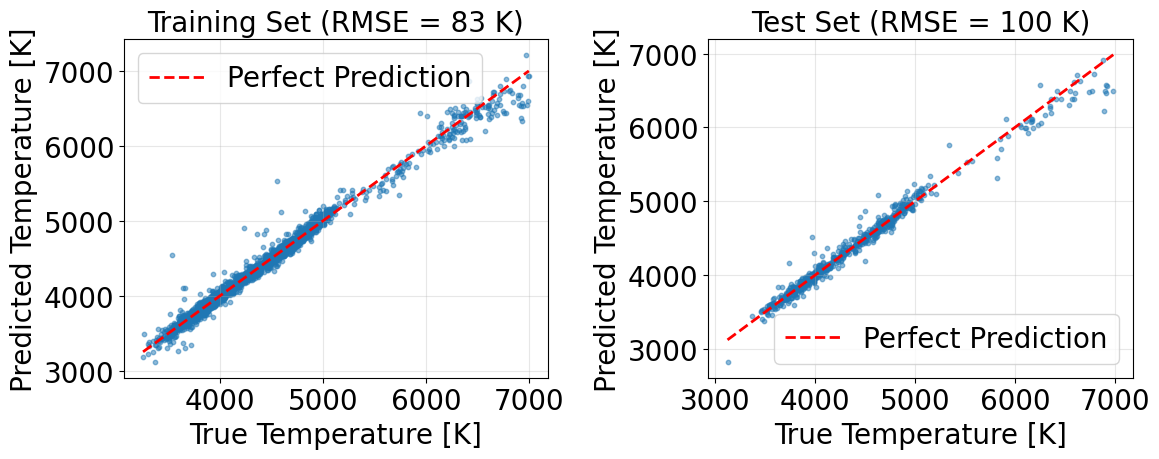

Model Comparison:
Unregularized - Training: 33.3 K, Test: 309.3 K
Regularized - Training: 83.0 K, Test: 100.1 K


In [8]:
# Compute weights with optimal regularization
w_optimal = compute_regularized_weights(Phi_train, t_train, best_lambda)

# Make predictions with optimal model
t_pred_train_opt = Phi_train @ w_optimal
t_pred_test_opt = Phi_test @ w_optimal

# Calculate RMSE for optimal model
train_rmse_opt = np.sqrt(np.mean((t_train - t_pred_train_opt)**2))
test_rmse_opt = np.sqrt(np.mean((t_test - t_pred_test_opt)**2))

# Visualize predictions
plt.figure(figsize=(12, 5))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(t_train, t_pred_train_opt, alpha=0.5, s=10)
plt.plot([t_train.min(), t_train.max()], [t_train.min(), t_train.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Temperature [K]')
plt.ylabel('Predicted Temperature [K]')
plt.title(f'Training Set (RMSE = {train_rmse_opt:.0f} K)')
plt.legend()
plt.grid(True, alpha=0.3)

# Test set
plt.subplot(1, 2, 2)
plt.scatter(t_test, t_pred_test_opt, alpha=0.5, s=10)
plt.plot([t_test.min(), t_test.max()], [t_test.min(), t_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Temperature [K]')
plt.ylabel('Predicted Temperature [K]')
plt.title(f'Test Set (RMSE = {test_rmse_opt:.0f} K)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison
print("Model Comparison:")
print(f"Unregularized - Training: {33.3:.1f} K, Test: {309.3:.1f} K")
print(f"Regularized - Training: {train_rmse_opt:.1f} K, Test: {test_rmse_opt:.1f} K")

The regularized model shows dramatically improved generalization. The test set predictions now cluster much more tightly around the diagonal, indicating that our model has learned genuine relationships between spectral features and temperature rather than memorizing training noise. The small difference between training and test performance (~20 K) suggests healthy generalization.

## Feature Engineering

While our regularized linear model performs well, we've so far assumed that temperature relates linearly to spectral flux values. This assumption may be overly restrictive—the relationship between spectral features and stellar parameters often involves nonlinearities due to the complex physics of stellar atmospheres.

One approach to capturing nonlinear relationships while maintaining the computational advantages of linear regression is to transform our input features using basis functions. By applying nonlinear transformations to our inputs, we can model nonlinear relationships in the original feature space while still solving a linear problem in the transformed space.

A natural extension is to include quadratic terms, allowing the model to capture second-order relationships. For each spectral pixel with flux $\phi_i$, we create an additional feature $\phi_i^2$. This transformation enables our model to learn that temperature might depend not just on the flux at a given wavelength, but also on its square—potentially capturing saturation effects in strong absorption lines or nonlinear temperature sensitivities.

However, this approach dramatically increases our feature space from 2,001 to 4,001 dimensions (2,000 linear + 2,000 quadratic + 1 bias term), exacerbating the risk of overfitting. This makes regularization even more critical.

In [9]:
def create_quadratic_features(Phi):
    """
    Create quadratic features by appending squared terms
    
    Parameters:
    -----------
    Phi : array, shape (n_samples, n_features)
        Original design matrix (including bias column)
        
    Returns:
    --------
    Phi_quad : array, shape (n_samples, 2*n_features - 1)
        Design matrix with quadratic features
        (we don't square the bias term)
    """
    # Separate features and bias
    features = Phi[:, :-1]  # All columns except last (bias)
    bias = Phi[:, -1:]      # Last column (bias)
    
    # Create quadratic features
    features_squared = features ** 2
    
    # Combine: [features, features_squared, bias]
    Phi_quad = np.hstack([features, features_squared, bias])
    
    return Phi_quad

# Create quadratic features for train and test sets
Phi_train_quad = create_quadratic_features(Phi_train)
Phi_test_quad = create_quadratic_features(Phi_test)

print(f"Original feature dimensions: {Phi_train.shape[1]}")
print(f"Quadratic feature dimensions: {Phi_train_quad.shape[1]}")
print(f"Feature expansion: {Phi_train.shape[1]} → {Phi_train_quad.shape[1]}")

# First, try without regularization to see what happens
print("\nTesting quadratic features without regularization...")
try:
    w_quad_unreg = np.linalg.inv(Phi_train_quad.T @ Phi_train_quad) @ Phi_train_quad.T @ t_train
    t_pred_train_quad_unreg = Phi_train_quad @ w_quad_unreg
    t_pred_test_quad_unreg = Phi_test_quad @ w_quad_unreg
    
    train_rmse_quad_unreg = np.sqrt(np.mean((t_train - t_pred_train_quad_unreg)**2))
    test_rmse_quad_unreg = np.sqrt(np.mean((t_test - t_pred_test_quad_unreg)**2))
    
    print(f"Quadratic model (no regularization):")
    print(f"Training RMSE: {train_rmse_quad_unreg:.1f} K")
    print(f"Test RMSE: {test_rmse_quad_unreg:.1f} K")
except np.linalg.LinAlgError:
    print("Matrix is singular! Cannot invert without regularization.")
    print("This demonstrates the severe overfitting with high-dimensional features.")


Original feature dimensions: 2001
Quadratic feature dimensions: 4001
Feature expansion: 2001 → 4001

Testing quadratic features without regularization...
Quadratic model (no regularization):
Training RMSE: 926754.3 K
Test RMSE: 1223107.2 K


Given the high dimensionality of our quadratic feature space, regularization becomes essential. Let's search for the optimal regularization parameter for our expanded feature set:


In [10]:
# Search for optimal lambda with quadratic features
lambda_values_quad = np.logspace(-3, 2, 20)
results_quad = []

for lambda_reg in lambda_values_quad:
    # Compute regularized weights for quadratic features
    w_reg_quad = compute_regularized_weights(Phi_train_quad, t_train, lambda_reg)
    
    # Compute predictions
    t_pred_train_quad = Phi_train_quad @ w_reg_quad
    t_pred_test_quad = Phi_test_quad @ w_reg_quad
    
    # Compute RMSE
    train_rmse_quad = np.sqrt(np.mean((t_train - t_pred_train_quad)**2))
    test_rmse_quad = np.sqrt(np.mean((t_test - t_pred_test_quad)**2))
    
    results_quad.append({
        'lambda': lambda_reg,
        'train_rmse': train_rmse_quad,
        'test_rmse': test_rmse_quad
    })

# Convert to array for analysis
results_quad_array = np.array([(r['lambda'], r['train_rmse'], r['test_rmse']) 
                               for r in results_quad])

# Find optimal lambda for quadratic model
best_idx_quad = np.argmin(results_quad_array[:, 2])
best_lambda_quad = results_quad_array[best_idx_quad, 0]
best_test_rmse_quad = results_quad_array[best_idx_quad, 2]

print(f"Optimal λ for quadratic features: {best_lambda_quad:.2f}")
print(f"Best test RMSE with quadratic features: {best_test_rmse_quad:.1f} K")
print(f"\nComparison:")
print(f"Linear features: ~100 K")
print(f"Quadratic features: ~{best_test_rmse_quad:.0f} K")


Optimal λ for quadratic features: 0.23
Best test RMSE with quadratic features: 96.9 K

Comparison:
Linear features: ~100 K
Quadratic features: ~97 K


The minimal improvement from quadratic features teaches us several important lessons:

1. **Complexity vs. Performance Trade-off**: Doubling our feature space yielded only a ~3% improvement in prediction accuracy. This suggests that the linear relationships between spectral features and temperature already capture most of the predictable signal.

2. **Regularization Becomes More Critical**: The quadratic model required stronger regularization (λ ≈ 0.23 vs. 0.07), reflecting the increased risk of overfitting with higher-dimensional feature spaces.

3. **Domain Knowledge Matters**: Rather than blindly adding polynomial features, a more effective approach might leverage astrophysical insights—for instance, focusing on specific temperature-sensitive line ratios or regions of the spectrum known to correlate strongly with stellar parameters.

This example illustrates a fundamental principle in machine learning: more complex models aren't always better. The regularized linear model achieves most of the possible performance while remaining simpler to interpret and computationally efficient. In practice, the choice between simple or complex features would depend on whether the small improvement justifies the added complexity for your specific application.


## Summary

This tutorial has demonstrated the power and limitations of linear regression through a practical astronomical application. By working with real APOGEE spectra, we've explored fundamental concepts that extend far beyond this specific problem:

1. **Maximum Likelihood Estimation**: We implemented the analytical MLE solution for linear regression, seeing how it emerges naturally from probabilistic principles. The closed-form solution $\mathbf{w}_{\text{MLE}} = (\mathbf{\Phi}^T \mathbf{\Phi})^{-1} \mathbf{\Phi}^T \mathbf{t}$ provides global optimality—a luxury we won't have with more complex models.

2. **The Overfitting Phenomenon**: Our initial model achieved exceptional training performance (~30 K) but failed catastrophically on test data (~300 K). This dramatic example illustrates why validation on held-out data is essential for any machine learning application.

3. **Regularization as a Solution**: By adding an L2 penalty term, we transformed an unusable model into one achieving ~100 K precision—approaching the performance of professional pipelines. The regularization parameter λ controls the bias-variance trade-off, with optimal values found through cross-validation.

4. **Feature Engineering**: The quadratic features provided only marginal improvement in our specific case—predicting temperature over a relatively narrow range where linear relationships suffice. However, this doesn't diminish the general importance of feature engineering. For more complex stellar parameters or wider parameter ranges, nonlinear features might prove essential. The key lesson is to let the data and validation metrics guide model complexity decisions.

The principles explored here—maximum likelihood estimation, regularization, and feature engineering—form the foundation for more sophisticated methods. As we progress to Bayesian approaches, nonlinear models, and deep learning, these concepts will reappear in new guises, but the fundamental challenges remain the same: extracting meaningful patterns from data while avoiding overfitting.
